In [1]:
import fasttext, numpy as np, pandas as pd
import fasttext.util
# READS THE FILE INTO A DATAFRAME
df = pd.read_excel("annotations.xlsx")
# CREATES A DATAFRAME WITH ONLY THE COLUMNS WE NEED
dfx = [i.split(" ") for i in df.text]
dfx = np.array(dfx)
# ONE HOT ENCODES THE RESULT
dfy = pd.get_dummies(df.type)
ftfile = open("format.txt", "w")
# WRITES THE FILE FOR FASTTEXT
for i in df.text:
    ftfile.write(i + "\n")
ftfile.close()
# TRAINS ALL THE MODELS
ftmodel_cbow = fasttext.train_unsupervised("format.txt", model='cbow')
ftmodel_skipgram = fasttext.train_unsupervised("format.txt", model='skipgram')
ftmodel = fasttext.load_model("fastText/cc.en.300.bin")
# REDUCES WORD VECTORS TO LENGTH 2 (WORD VECTORS COME IN THE FORM OF A LIST)
fasttext.util.reduce_model(ftmodel, 2)
fasttext.util.reduce_model(ftmodel_cbow, 2)
fasttext.util.reduce_model(ftmodel_skipgram, 2)

<ipython-input-1-f041ac669b9b>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dfx = np.array(dfx)


In [2]:
# REASSIGNMENT
vectorizer1 = ftmodel
vectorizer2 = ftmodel_cbow
vectorizer3 = ftmodel_skipgram

In [3]:
# REARRANGES WORD MATRICES FOR CODING PURPOSES
words1 = np.zeros(shape = (17775, 100, 2), dtype = 'float')
for i in range(17775):
    for j in range(len(dfx[i])):
        words1[i][j] = vectorizer1.get_word_vector(dfx[i][j])

words2 = np.zeros(shape = (17775, 100, 2), dtype = 'float')
for i in range(17775):
    for j in range(len(dfx[i])):
        words2[i][j] = vectorizer2.get_word_vector(dfx[i][j])

words3 = np.zeros(shape = (17775, 100, 2), dtype = 'float')
for i in range(17775):
    for j in range(len(dfx[i])):
        words3[i][j] = vectorizer3.get_word_vector(dfx[i][j])

In [4]:
# CREATES TOKENIZERS THORUGH THE WORD VECTORS
from keras.preprocessing.text import Tokenizer
vocab_size = len(ftmodel.words)
tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")
tokenizer.fit_on_texts(dfx)
# CREATES INPUT DATAFRAME
dfx_nums = tokenizer.texts_to_sequences(dfx)
from keras.preprocessing.sequence import pad_sequences
dfx_nums_padded = pad_sequences(dfx_nums, maxlen = 100, padding = 'post', truncating = 'post')
# CREATES EMBEDDING MATRIX FOR EMBEDDING LAYER
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 2))
for word, i in tokenizer.word_index.items():
    embedding_vector = vectorizer3.get_word_vector(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [6]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dropout, Dense, Embedding, Bidirectional
from sklearn.model_selection import train_test_split
# CREATES EMBEDDING LAYER
embedding_layer = Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 2, weights = [embedding_matrix], trainable = False)
# CREATES MODEL
def buildmodel():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(input_dim = 100, filters = 30, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Bidirectional(LSTM(units = 23, return_sequences = False)))#when activated sigmoid goes to 0.4025
    model.add(Dropout(rate = 0.05))
    model.add(Dense(units = 20, activation = 'relu', kernel_regularizer = keras.regularizers.l2(l = 0.001)))#DELETE THIS ACTIVATION FUNCTION
    model.add(Dense(units = 3, activation = 'sigmoid',))
    opt = keras.optimizers.Adam(learning_rate = 0.002)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


#actually build the model to generate the object
model_ver2 = buildmodel()
X_train, X_test, y_train, y_test = train_test_split(dfx_nums_padded, dfy, test_size=0.2, random_state=42)
#model
# history = model.fit(X_train,y_train, epochs = 5)
ver2_history = model_ver2.fit(dfx_nums_padded, dfy, validation_split=0.33, epochs=50, verbose=1)

Epoch 1/50
373/373 [==============================] - 39s 84ms/step - loss: 0.6197 - accuracy: 0.4134 - val_loss: 0.6104 - val_accuracy: 0.4368
Epoch 2/50
373/373 [==============================] - 29s 77ms/step - loss: 0.6062 - accuracy: 0.4413 - val_loss: 0.5995 - val_accuracy: 0.4410
Epoch 3/50
373/373 [==============================] - 30s 80ms/step - loss: 0.5972 - accuracy: 0.4513 - val_loss: 0.5982 - val_accuracy: 0.4548
Epoch 4/50
373/373 [==============================] - 30s 80ms/step - loss: 0.5928 - accuracy: 0.4607 - val_loss: 0.5948 - val_accuracy: 0.4668
Epoch 5/50
373/373 [==============================] - 30s 80ms/step - loss: 0.5899 - accuracy: 0.4691 - val_loss: 0.5869 - val_accuracy: 0.4695
Epoch 6/50
373/373 [==============================] - 29s 78ms/step - loss: 0.5839 - accuracy: 0.4853 - val_loss: 0.5852 - val_accuracy: 0.4720
Epoch 7/50
373/373 [==============================] - 29s 78ms/step - loss: 0.5808 - accuracy: 0.4985 - val_loss: 0.5800 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


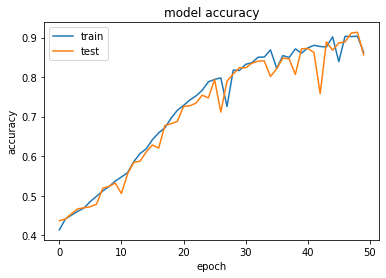

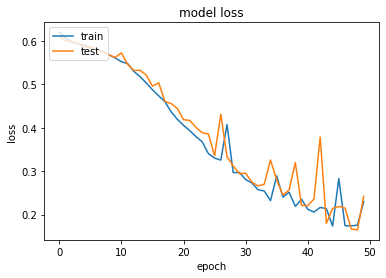

In [7]:
# list all data in history
print(ver2_history.history.keys())

import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(ver2_history.history['accuracy'])
plt.plot(ver2_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(ver2_history.history['loss'])
plt.plot(ver2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()